# Combine sgRNAs
Here we get a dataframe of all sgRNAs for all processed datasets to use for scoring

In [11]:
import pandas as pd
from scipy import stats
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import gpplot
import seaborn as sns

from core import (add_xy_line,
                  setup_plots,
                  no_clip)
from datasets import dataset_list

We need to load the datasets first

In [2]:
setup_plots()

In [3]:
for ds in dataset_list:
    ds.load_data()

In [4]:
dataset_summaries = []
for ds in dataset_list:
    ds_summary = dict()
    ds_summary['name'] = ds.name
    ds_summary['n_sgRNAs'] = ds.dataset.shape[0]
    if ds.sgrna_group_col is not None:
        ds_summary['n_groups'] = ds.dataset[ds.sgrna_group_col].nunique()
    dataset_summaries.append(ds_summary)

dataset_summary_df = pd.DataFrame(dataset_summaries)
dataset_summary_df.sort_values('n_sgRNAs')

,name,n_sgRNAs,n_groups
6,Kim2019_test,536,NaN
3,Doench2014_human,995,3.0
9,Wang2014,1022,29.0
2,Doench2014_mouse,1169,7.0
1,Chari2015,1202,NaN
4,Doench2016,2536,8.0
8,Shalem_2014,4766,1249.0
7,Koike-Yusa2014,6689,1437.0
11,Behan2019,7442,1519.0
0,Aguirre2017,8659,1532.0


## Overlap between datasets

For each dataset we'll calculate the fraction of sgRNAs that each library shares with one another.

### Activity of overlapping sgRNAs

Most datasets show agreement between the activity of overlapping sgRNAs, except for the Shalem dataset
(GeckoV1), which typically showed lower correlation values.

<ipython-input-5-fb86606c66a4>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


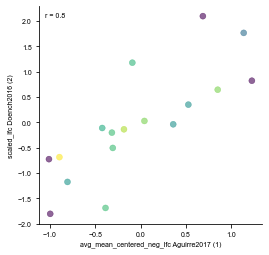

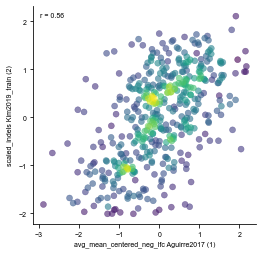

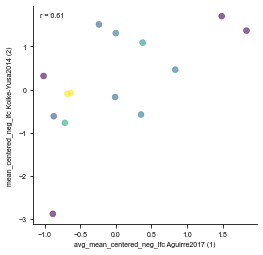

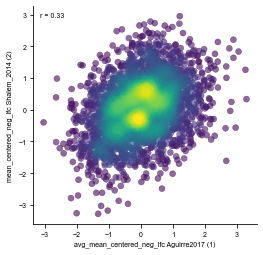

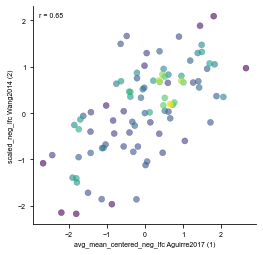

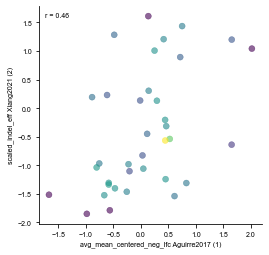

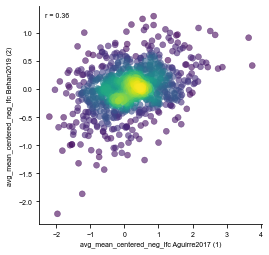

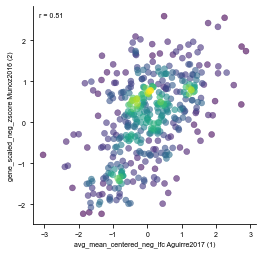

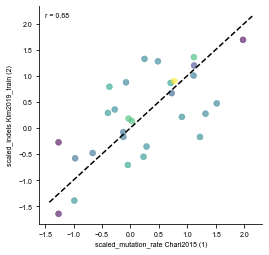

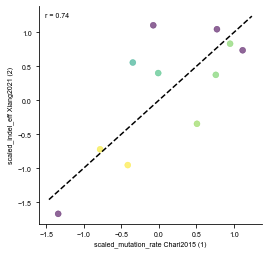

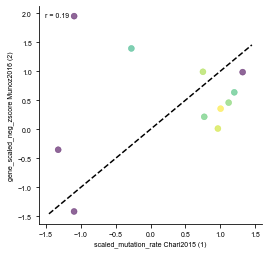

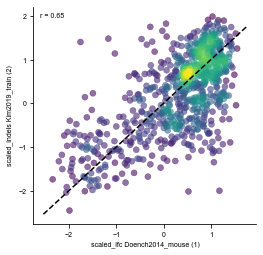

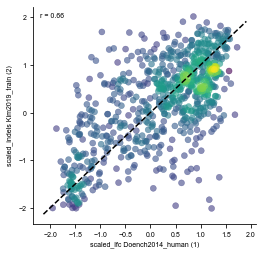

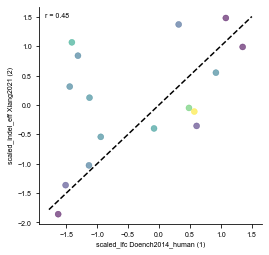

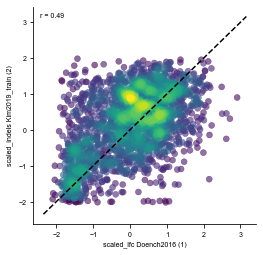

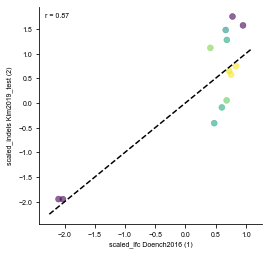

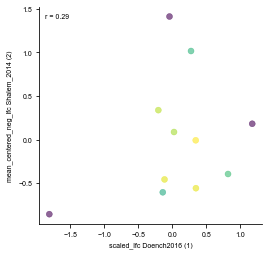

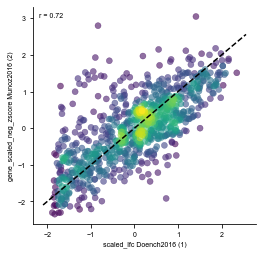

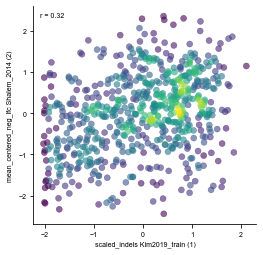

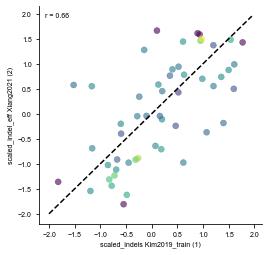

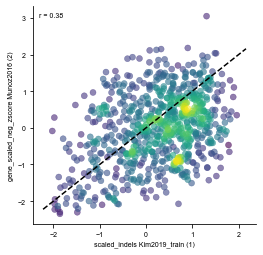

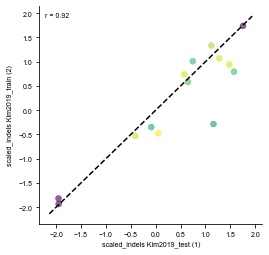

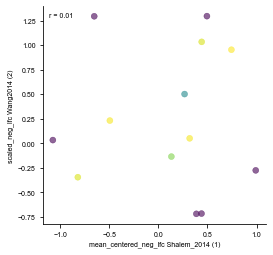

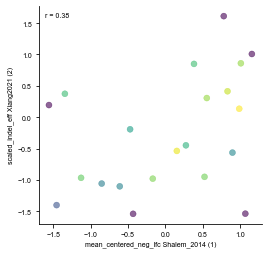

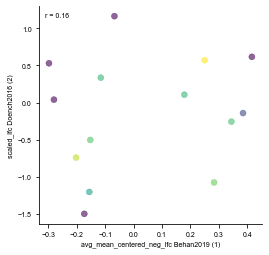

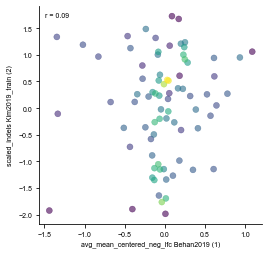

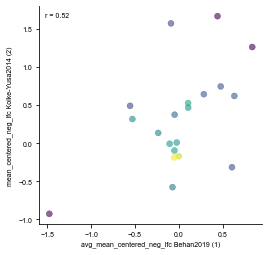

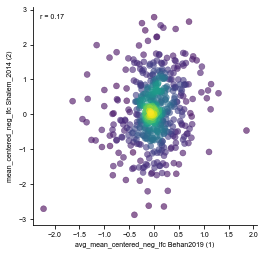

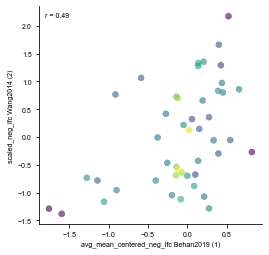

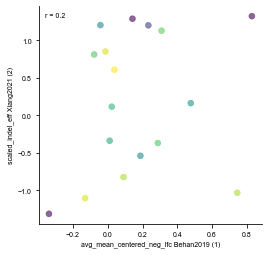

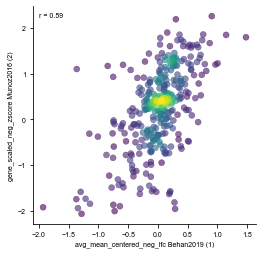

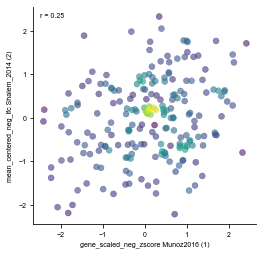

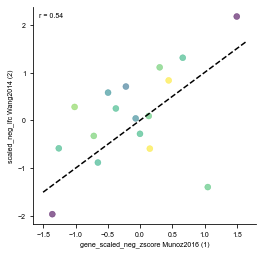

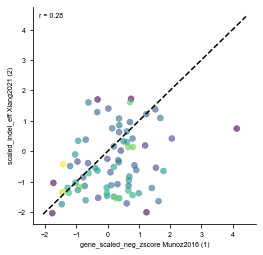

In [5]:
dataset_overlaps = []
for ds1 in dataset_list:
    for ds2 in dataset_list:
        if ds1 != ds2:
            dataset_overlap = dict()
            dataset_overlap['name_1'] = ds1.name
            dataset_overlap['name_2'] = ds2.name
            common_context = (ds1.dataset[ds1.context_seq_col]
                              .isin(ds2.dataset[ds2.context_seq_col])
                              .sum())
            dataset_overlap['overlap'] = common_context
            if common_context > 10:
                ds1_rename = ds1.rank_col + ' ' + ds1.name + ' (1)'
                ds2_rename = ds2.rank_col + ' ' + ds2.name + ' (2)'
                merged_data = (ds1.dataset
                               .rename({ds1.rank_col: ds1_rename}, axis=1)
                               .merge(ds2.dataset
                                      .rename({ds2.rank_col: ds2_rename}, axis=1),
                                      how='inner',
                                      left_on=ds1.context_seq_col, right_on=ds2.context_seq_col))
                if ds1.name < ds2.name:
                    plt.subplots(figsize=(4, 4))
                    gpplot.point_densityplot(merged_data, x=ds1_rename,
                                             y=ds2_rename)
                    gpplot.add_correlation(merged_data, x=ds1_rename,
                                           y=ds2_rename)
                    sns.despine()
                    if (not ds1.genomewide) and (not ds2.genomewide):
                        add_xy_line()
                cor = stats.pearsonr(merged_data[ds1_rename],
                                     merged_data[ds2_rename])[0]
                dataset_overlap['activity_cor'] = cor
            dataset_overlaps.append(dataset_overlap)

dataset_overlap_df = pd.DataFrame(dataset_overlaps)
filtered_overlap = dataset_overlap_df[(dataset_overlap_df['overlap'] > 0)].reset_index(drop=True)
# directional overlap
filtered_overlap = (filtered_overlap.merge(dataset_summary_df
                                           .rename({'name': 'name_1'}, axis=1),
                                           how='inner', on='name_1'))
filtered_overlap['fraction_overlap'] = filtered_overlap['overlap']/filtered_overlap['n_sgRNAs']

In [111]:
G = nx.from_pandas_edgelist(filtered_overlap, 'name_1', 'name_2', 'fraction_overlap',
                            create_using=nx.DiGraph())
node_n_sgrnas = (dataset_summary_df[['name', 'n_sgRNAs']]
                 .set_index('name')
                 .to_dict(orient='index'))
nx.set_node_attributes(G, node_n_sgrnas)
# layout
pos = nx.spring_layout(G, seed=7, iterations=100)
node_df = (pd.merge(pd.DataFrame(node_n_sgrnas).T,
                    pd.DataFrame(pos).T, left_index=True, right_index=True,
                    how='inner')
           .reset_index()
           .rename({'index': 'dataset',
                    0: 'x',
                    1: 'y'}, axis=1))
edge_df = (nx.to_pandas_edgelist(G)
           .merge(node_df, how='inner',
                  left_on='source', right_on='dataset')
           .merge(node_df, how='inner',
                  left_on='target', right_on='dataset',
                  suffixes=('_source', '_target')))
edge_df['name'] = edge_df['dataset_target'] + edge_df['dataset_source']

In [99]:
def get_center_point(posA, posB, rad):
    """Get center point for defining a bezier curve"""
    x1, y1 = posA
    x2, y2 = posB
    x12, y12 = (x1 + x2) / 2., (y1 + y2) / 2.
    dx, dy = x2 - x1, y2 - y1
    f = rad
    cx, cy = x12 + f * dy, y12 - f * dx
    return cx, cy

def bezier_equation(p0, p1, p2, t):
    return (1-t)*((1-t)*p0 + t*p1) + t*((1-t)*p1 + t*p2)

def get_bezier_curve(posA, posB, rad=0.2, nsteps=100,
                     x_name='x', y_name='y'):
    center = get_center_point(posA, posB, rad=rad)
    p0 = np.array(posA)
    p1 = np.array(center)
    p2 = np.array(posB)
    curve = [bezier_equation(p0, p1, p2, t) for t in np.linspace(0, 1, nsteps)]
    curve_df = (pd.DataFrame(curve)
                .rename({0: x_name,
                         1: y_name}, axis=1))
    return curve_df

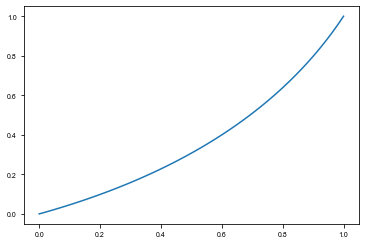

In [97]:
test = get_bezier_curve([0, 0], [1, 1], rad=0.2)
plt.plot(test[0], test[1])

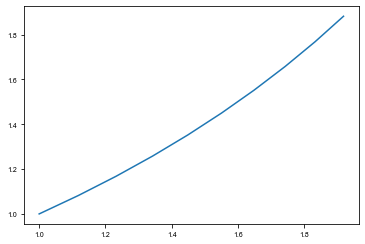

In [82]:
curve_df = pd.DataFrame(curve)
plt.plot(curve_df[0], curve_df[1])

<ipython-input-43-444dae4f14c3>:11: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


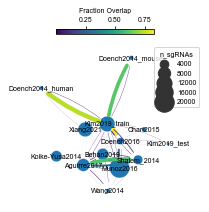

In [43]:
fig, ax = plt.subplots(figsize=(3.5,3.7))

# edges
edge_width = [d['fraction_overlap']*6 for u, v, d in G.edges(data=True)]
edge_color_scale = [d['fraction_overlap'] for u, v, d in G.edges(data=True)]
edges = nx.draw_networkx_edges(G, pos, arrowstyle="-", connectionstyle="arc3,rad=0.1",
                               width=edge_width, edge_color=edge_color_scale,
                               arrowsize=5)
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.viridis)
pc.set_array(edge_color_scale)
plt.colorbar(pc, label='Fraction Overlap', location='top',
             shrink=0.5)
# nodes
#node_size = [d['n_sgRNAs'] * 0.02 for n, d in G.nodes(data=True)]
#nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='tab:blue')
sns.scatterplot(data=dataset_pos, x='x', y='y', color='tab:blue',
                size='n_sgRNAs', sizes=(10, 400))

## node legend
# n_legend_nodes = 4
# min_node_size_legend = int(round(min(node_size), -2))
# max_node_size_legend = int(round(max(node_size), -2))
# node_step = ceil((max_node_size_legend -  min_node_size_legend)/n_legend_nodes)
# node_size_legend = range(min_node_size_legend, max_node_size_legend, node_step)
# node_size_nsgrnas = [x/0.02 for x in node_size_legend]
# node_handles = [Line2D([0], [0], marker='o',
#                        markerfacecolor='tab:blue',
#                        markersize=s) for s in
#                 node_size_legend]
# plt.legend(node_handles, node_size_nsgrnas)

# labels
nx.draw_networkx_labels(G, pos, font_size=7,
                        font_family='Arial')
plt.axis('off')
plt.margins(x=0.2)
no_clip(ax)
gpplot.savefig('../figures/dataset_overlap.pdf')


AttributeError: 'Line2D' object has no property 'arrowstyle'

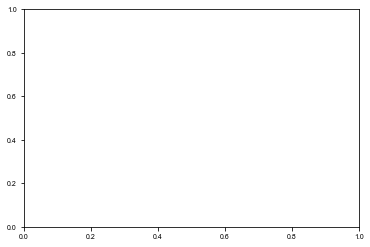

In [28]:
test = pd.DataFrame({'a': [1, 3, 3, 1], 'b': [0, 2, 0, 2],
                     's': [1, 1, 2, 2]})
sns.lineplot(data=test, x='b', y='a', size='s',
             arrowstyle="-", connectionstyle="arc3,rad=0.1")




In [26]:
pd.DataFrame(pos)

,Aguirre2017,Chari2015,Doench2016,Kim2019_train,Koike-Yusa2014,Shalem_2014,Wang2014,Xiang2021,Behan2019,Munoz2016,Doench2014_mouse,Doench2014_human,Kim2019_test
0,-0.187568,0.271658,0.091627,-0.007209,-0.390562,0.225549,0.000178,-0.172873,-0.040919,0.085683,0.174713,-0.503974,0.453696
1,-0.318867,0.117417,-0.024781,0.186166,-0.211274,-0.255107,-0.637158,0.118298,-0.186277,-0.355742,1.000000,0.626975,-0.059650


## Getting list of all sgRNAs

In [7]:
sgrna_dfs_list = list()
for ds in dataset_list:
    print(ds.name)
    sgrna_dfs_list.append(ds.get_sg_df())

sgrna_df = (pd.concat(sgrna_dfs_list)
            .drop_duplicates())

print(sgrna_df.shape[0])

Aguirre2017
Chari2015
Doench2014_mouse
Doench2014_human
Doench2016
Kim2019_train
Kim2019_test
Koike-Yusa2014
Shalem_2014
Wang2014
Xiang2021
Behan2019
Munoz2016
70171


In [8]:
sgrna_df['PAM Sequence'].value_counts()

TGG    25699
AGG    22134
GGG    11986
CGG    10352
Name: PAM Sequence, dtype: int64

In [9]:
lower_seqs = sgrna_df.loc[sgrna_df['sgRNA Context Sequence'].str.contains('a|c|t|g'), 'sgRNA Sequence']
for ds in dataset_list:
    ds.set_sgrnas()
    if pd.Series(list(ds.sgrnas)).isin(lower_seqs).any():
        print(ds.name)

In [10]:
sgrna_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,AGG
...,...,...,...
21130,TTTGTTCATACTTGCAGAGT,GATGTTTGTTCATACTTGCAGAGTTGGACA,TGG
21132,TTTGTTCTTTCTGTGCGCAC,AGATTTTGTTCTTTCTGTGCGCACTGGTGA,TGG
21133,TTTGTTGAGGCTCCTGGCTG,AAGATTTGTTGAGGCTCCTGGCTGTGGCGA,TGG
21134,TTTGTTGCCAATAGTTGGCC,TCTTTTTGTTGCCAATAGTTGGCCTGGCAA,TGG


In [11]:
# write fasta for crispron
with open('../data/interim/rs_dev_all_sgrnas.fa', 'w') as f:
    for context in sgrna_df['sgRNA Context Sequence']:
        f.write('>' + context + '\n')
        f.write(context + '\n')

In [12]:
sgrna_df.to_csv('../data/interim/rs_dev_all_sgrnas.csv', index=False)
filtered_overlap.to_csv('../data/processed/dataset_overlap.csv', index=False)